In [5]:
#########################
## Importing libraries ##
#########################

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#########################
## Dataset downloading ##
#########################

# Import CIFAR-10 dataset from HuggingFace
# Run this first in terminal: pip install datasets

from datasets import load_dataset

train_set = load_dataset(
    'cifar10',
    split='train', # Download the training set
    verification_mode='basic_checks'  # checks if the data files exist and verifies basic metadata
)

print(train_set)

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


In [16]:
val_set =  load_dataset(
    'cifar10',
    split='test', # Download the training set
    verification_mode='basic_checks'  # checks if the data files exist and verifies basic metadata
)

print(val_set)

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


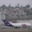

In [13]:
# View an image
train_set[0]['img']

In [ ]:
print(train_set[0]['img'])
# <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A2EBA2F0410>

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7A2EBA2F0410>


In [ ]:
#########################
## Image preprocessing ##
#########################

IMG_SIZE = 32
'''
Most CNNs are designed to only accept images of a fixed size
=> Must fix the IMG_SIZE, and reshape the input to adapt this norm.
'''

#----
## Build preprocess transforms
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the input image to a given size (IMG_SIZE, IMG_SIZE)
        transforms.ToTensor()                  # Convert to tensor (and also convert to [0, 1] tensors)
    ]
)

#----
## Change from grayscale to RGB, and apply preprocess
#----

from tqdm.auto import tqdm

inputs_train = []

for record in tqdm(iterable=train_set, desc="Preprocessing Images"):
    image = record['img']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocession
    input_tensor = preprocess(image)
    
    # append to inputs_train
    inputs_train.append([input_tensor, label])


Preprocessing Images:   0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
#----
## Re-normalize the pixel values for train set
#----
'''
Since transforms.Tensor() normalizes all into [0, 1],
we need to modify this normalization to fit this dataset.

Doing so by calculating the mean and std for all images across separe 3 color channles
then use transforms.Normalize(mean=, std=) with this calculated mean and std.
'''

# First, we need to calculate the mean and std for each of the RGB channels across all images

import numpy as np

# Choosing a random sample to calculate mean and std (this sample containing random 512 images)
np.random.seed(0)
idx = np.random.randint(0, len(inputs_train), 512)

# Concatenate this subset of images into a new tensor )tensor_placeholder)
tensor_placeholder = torch.concat([inputs_train[i][0] for i in idx], axis=1)
print(tensor_placeholder.shape)
# torch.Size([3, 16384, 32])
'''
we concatenate 512 images of size (3x32x32) (Channel*Height*Width) along the Height channel
=> (3x16384x32), 16384=32*512
'''

# Calculate the mean and std across all images, for separate channel
mean_all = torch.mean(tensor_placeholder, dim=(1, 2)) # dim=(1, 2) meanin only uses Heigh*Width for calculation, ignore the channel
std_all = torch.std(tensor_placeholder, dim=(1, 2))

print(mean_all) # tensor([0.4855, 0.4792, 0.4421])
print(std_all) # tensor([0.2464, 0.2418, 0.2599])

#### RE-NORMALIZE ###

preprocess = transforms.Compose([transforms.Normalize(mean=mean_all, std=std_all)])

for idx in tqdm(range(len(inputs_train))):
    input_tensor = preprocess(inputs_train[idx][0])
    inputs_train[idx][0] = input_tensor # replace with re-normalized tensor

torch.Size([3, 16384, 32])
tensor([0.4855, 0.4792, 0.4421])
tensor([0.2464, 0.2418, 0.2599])


  0%|          | 0/50000 [00:00<?, ?it/s]

In [39]:

#----
## Re-normalize the pixel values for val set
#----

preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the input image to a given size (IMG_SIZE, IMG_SIZE)
        transforms.ToTensor(),                  # Convert to tensor (and also convert to [0, 1] tensors)
        transforms.Normalize(mean=mean_all, std=std_all) # Re-normalize with new mean and std
    ]
)

inputs_val = []

for record in tqdm(iterable=val_set, desc="Preprocessing Images"):
    image = record['img']
    label = record['label']
    
    # Convert from grayscale to RGB (3-colour channels)
    if image.mode == "L":
        image = image.convert("RGB")
        
    # preprocession
    input_tensor = preprocess(image)
    
    # append to inputs_train
    inputs_val.append([input_tensor, label])

Preprocessing Images:   0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
################
## Dataloader ##
################

BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(inputs_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(inputs_val, batch_size=BATCH_SIZE, shuffle=False)